<a href="https://colab.research.google.com/github/SHREERAJ11/DL-Simplified/blob/main/Roadmark%20Detection/Model/Unet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!cp kaggle.json /.kaggle/

cp: cannot create regular file '/.kaggle/': Not a directory


In [4]:
!chmod 600 /.kaggle/kaggle.json

chmod: cannot access '/.kaggle/kaggle.json': No such file or directory


In [5]:
!kaggle datasets download pkdarabi/road-mark-detection

Dataset URL: https://www.kaggle.com/datasets/pkdarabi/road-mark-detection
License(s): Attribution 4.0 International (CC BY 4.0)
road-mark-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip road-mark-detection.zip

Archive:  road-mark-detection.zip
replace data.yaml? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
# Importing initial libraries
import os
import cv2
import numpy as np

In [8]:
# Defining the data directories
train_dir = '/content/train'
valid_dir = '/content/valid'
test_dir = '/content/test'

In [9]:
# Function to load images and their corresponding labels
def load_images_and_labels(directory):
    images = []
    labels = []
    image_files = os.listdir(os.path.join(directory, 'images'))
    label_files = os.listdir(os.path.join(directory, 'labels'))

    for image_file in image_files:
        if image_file.endswith('.jpg'):
            img_path = os.path.join(directory, 'images', image_file)
            img = cv2.imread(img_path)
            if img is None:
                print(f'Failed to load image at path: {img_path}')
                continue
            label_file = image_file.replace('.jpg', '.txt')
            if label_file in label_files:
                label_path = os.path.join(directory, 'labels', label_file)
                with open(label_path, 'r') as f:
                    label_data = f.read().strip().split('\n')
                    label = np.zeros((640, 640), dtype=np.float32)
                    for line in label_data:
                        elements = line.split()
                        if len(elements) < 9:
                            print(f"Ignoring malformed line in {label_file}: {line}")
                            continue
                        label_id = int(elements[0])
                        try:
                            points = np.array(elements[1:], dtype=np.float32).reshape(-1, 2)
                            points = (points * 640).astype(np.int32)
                            cv2.fillPoly(label, [points], 1)
                        except ValueError as e:
                            print(f"Error parsing label for {image_file}: {e}")
                    images.append(img)
                    labels.append(label)
    return np.array(images), np.array(labels)

In [10]:
# Load the images and the labels
train_images, train_labels = load_images_and_labels(train_dir)
valid_images, valid_labels = load_images_and_labels(valid_dir)
test_images, test_labels = load_images_and_labels(test_dir)

Ignoring malformed line in 41_jpg.rf.9623d6f50ea3478f4ea82d0711b6f21e.txt: 


In [11]:
# Printing the shape of the data
print('Train images shape : ', train_images.shape)
print('Train labels shape : ', train_labels.shape)
print('Valid images shape : ', valid_images.shape)
print('Valid labels shape : ', valid_labels.shape)
print('Test images shape : ', test_images.shape)
print('Test labels shape : ', test_labels.shape)

Train images shape :  (2167, 640, 640, 3)
Train labels shape :  (2167, 640, 640)
Valid images shape :  (417, 640, 640, 3)
Valid labels shape :  (417, 640, 640)
Test images shape :  (192, 640, 640, 3)
Test labels shape :  (192, 640, 640)


In [12]:
#Print the number of unique labels
print('Number of unique (train) labels : ', len(np.unique(train_labels)))

Number of unique (train) labels :  2


In [13]:
!pip install tensorflow==2.9.1
#!pip install keras==2.4.3
!pip install segmentation-models==1.0.1

In [14]:
import tensorflow as tf
from segmentation_models import Unet
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

Segmentation Models: using `keras` framework.


In [15]:
from sklearn.model_selection import train_test_split

In [16]:
# Normalizing the images
train_images = train_images / 255.0
valid_images = valid_images / 255.0
test_images = test_images / 255.0

In [17]:
# To ensure the labels are binary
train_labels = (train_labels > 0).astype(np.float32)
valid_labels = (valid_labels > 0).astype(np.float32)
test_labels = (test_labels > 0).astype(np.float32)

In [18]:
# Ensure labels have shape (640, 640, 1)
train_labels = np.expand_dims(train_labels, axis=-1)
valid_labels = np.expand_dims(valid_labels, axis=-1)
test_labels = np.expand_dims(test_labels, axis=-1)

In [19]:
# Define the U-Net model
model = Unet(input_shape=(640, 640, 3), classes=1, activation='sigmoid')

In [20]:
# Compile the model
model.compile(optimizer='adam', loss=bce_jaccard_loss, metrics=[iou_score])

In [21]:
#Train the model
history = model.fit(
    train_images, train_labels,
    epochs=1,
    batch_size=64,
    validation_data=(valid_images, valid_labels)
)

34/34 [==============================] - 4620s 136s/step - loss: 1.1968 - iou_score: 0.0596 - val_loss: 1.1371 - val_iou_score: 0.0291


In [22]:
# Model Evaluation
test_loss, test_iou = model.evaluate(test_images, test_labels)
print(f'Test Loss: {test_loss}')
print(f'Test IoU: {test_iou}')

6/6 [==============================] - 41s 7s/step - loss: 1.1268 - iou_score: 0.0295
Test Loss: 1.1267637014389038
Test IoU: 0.029536180198192596


In [23]:
import matplotlib.pyplot as plt

6/6 [==============================] - 41s 7s/step


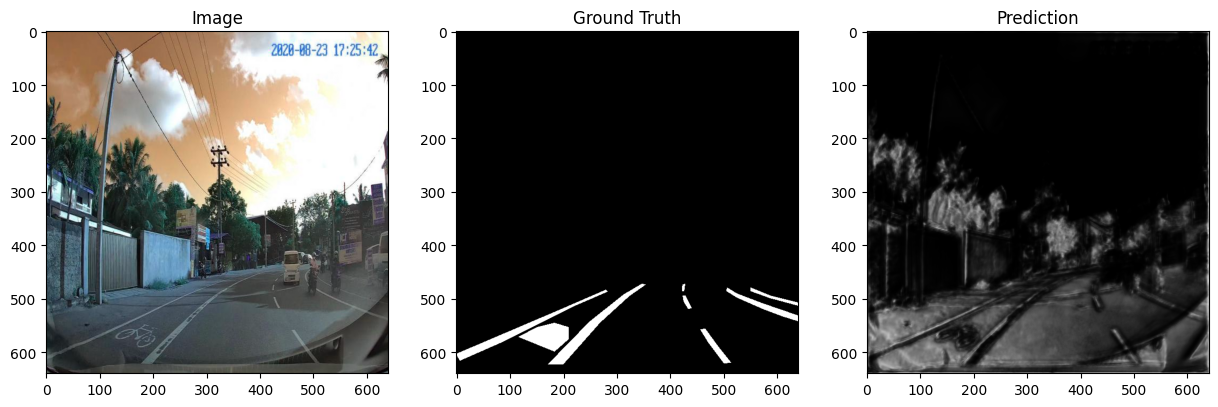

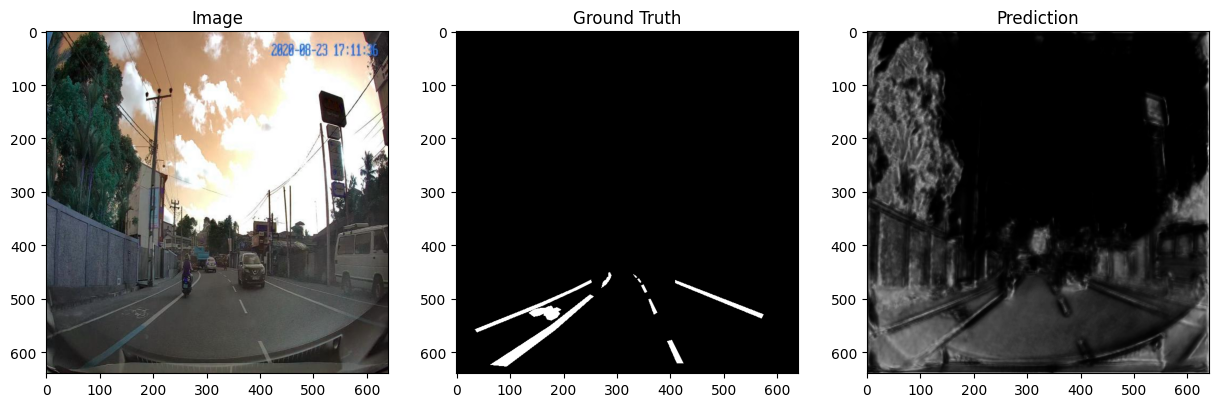

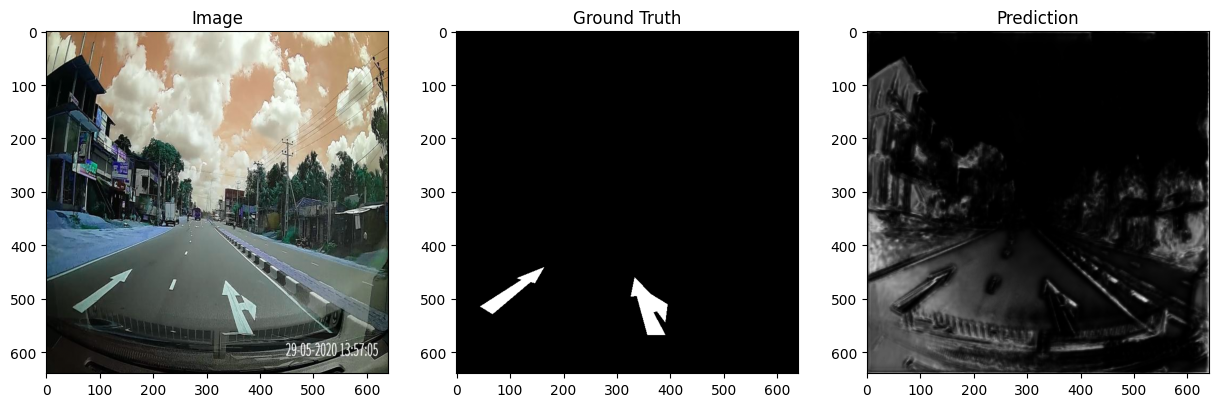

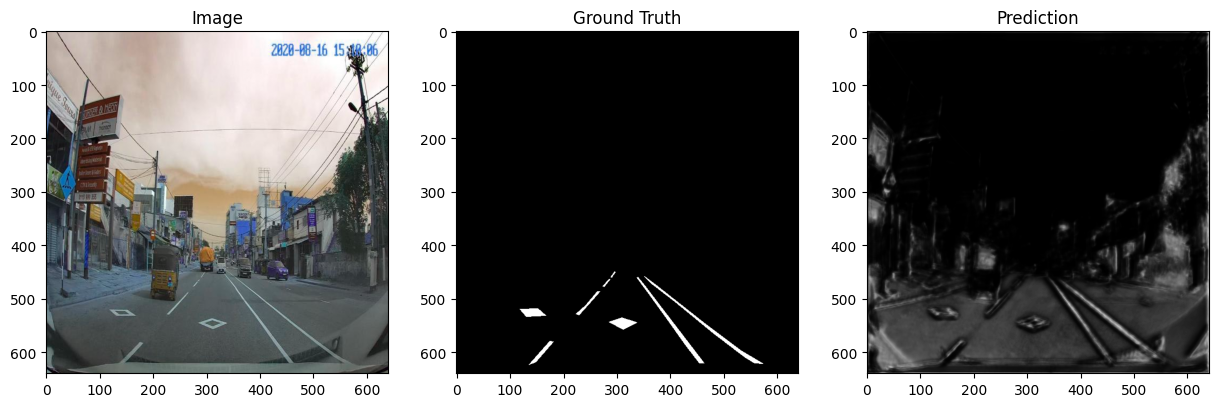

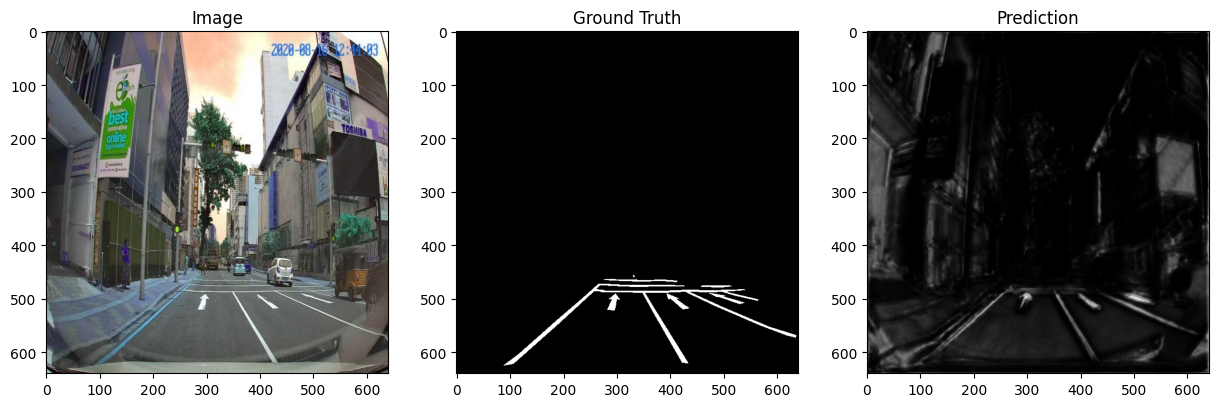

In [24]:
def visualize_predictions(images, labels, predictions, num_samples=5):
    for i in range(num_samples):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title('Image')
        plt.subplot(1, 3, 2)
        plt.imshow(labels[i].squeeze(), cmap='gray')
        plt.title('Ground Truth')
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title('Prediction')
        plt.show()

predictions = model.predict(test_images)
visualize_predictions(test_images, test_labels, predictions)